In [ ]:
# import gensim.downloader as api
# word_vecs = api.load("word2vec-google-news-300")
# word_vecs.save_word2vec_format('wv.bin', binary=True)

In [1]:
from utils.lstm_cnn import *
import torch
from torch import nn
import torch.nn.functional as F
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split

word_vecs = KeyedVectors.load_word2vec_format('wv.bin', binary=True)
pretrained_words = word_vecs.index2word
pretrained_vectors = word_vecs.vectors

In [2]:
import json

NUM_CATEGORIES = 5

categories = set()
all_data = []

with open('News_Category_Dataset_v2.json') as f:
    lines = f.readlines()
    for line in lines:
        data = json.loads(line)
        all_data.append(data)
        categories.add(data['category'])

sentences = []
labels = []

for data in all_data:
    sentences.append(data['headline'])
    labels.append(data['category'])

In [3]:
data_manager = DataManager(sentences, labels)
sentences, labels, cat2idx = data_manager.get_data_by_frequency(sentences, labels, NUM_CATEGORIES)
dataset_vocab = get_vocabulary(sentences)
word_vectors, word2idx = get_reduced_embedding_matrix(pretrained_words, pretrained_vectors, dataset_vocab)
tokenizer = Tokenizer(word2idx)
remove_null_data(sentences, labels, tokenizer)

In [4]:
X = sentences
y = [cat2idx[label] for label in labels]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

### LSTM Text Classifier

In [5]:
class LSTM(nn.Module):
    def __init__(self, output_size, embedding_dim, hidden_dim, word_vecs):
        super(LSTM, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(word_vectors, freeze=False)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True, 
                            bidirectional=True, num_layers=1)
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, nn_input, masks):
        seq_lens = torch.sum(masks, dim=1)
        seq_lens, indices = torch.sort(seq_lens, descending=True)
        nn_input = torch.index_select(nn_input, 0, indices)
        embeds = self.embedding(nn_input)
        embeds = nn.utils.rnn.pack_padded_sequence(embeds, seq_lens, batch_first=True)
        _, (output, _) = self.lstm(embeds)
        output = self.fc(torch.cat((output[-1], output[-2]), dim=1))
        _, indices = torch.sort(indices)
        output = torch.index_select(output, 0, indices)

        return output

In [6]:
class CNN(nn.Module):
    def __init__(self, output_size, embedding_dim, out_channels, word_vecs):
        super(CNN, self).__init__()
        
        self.embedding = nn.Embedding.from_pretrained(word_vecs, freeze=False)
        self.conv0 = nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=2, padding=1)
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=4, padding=1)
        self.conv3 = nn.Conv1d(in_channels=embedding_dim, out_channels=out_channels, kernel_size=5, padding=1)
        self.fc = nn.Linear(512, 41)
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, inputs, masks):
        embeds = self.embedding(inputs)
        embeds = embeds.transpose(1, 2)
        feat0 = F.relu(self.conv0(embeds))
        feat1 = F.relu(self.conv1(embeds))
        feat2 = F.relu(self.conv2(embeds))
        feat3 = F.relu(self.conv3(embeds))
        max0, _ = torch.max(feat0, dim=2)
        max1, _ = torch.max(feat1, dim=2)
        max2, _ = torch.max(feat2, dim=2)
        max3, _ = torch.max(feat3, dim=2)
        output = self.dropout(torch.cat((max0, max1, max2, max3), dim=1))
        output = self.fc(output)
        
        return output

In [7]:
embedding_dim = 300
output_size = NUM_CATEGORIES
hidden_dim = 128

lstm_classifier = LSTM(output_size, embedding_dim, hidden_dim, word_vectors).cuda()

In [8]:
learning_rate = 5e-5

lstm_optimizer = torch.optim.Adam(lstm_classifier.parameters(), lr=learning_rate)
lstm_criterion = nn.CrossEntropyLoss()

In [9]:
batch_size = 64
n_epochs = 9

lstm_summary = train_and_evaluate(lstm_classifier, lstm_criterion, accuracy, lstm_optimizer, X_train, 
                                  y_train, X_val, y_val, tokenizer, max_len=32, batch_size=batch_size, n_epochs=n_epochs)

start training: 
--------------------------------------------------
epoch  1 :
train loss: 0.5915; train acc: 0.6041
eval loss: 0.5698; eval acc: 0.8193
--------------------------------------------------
epoch  2 :
train loss: 0.4028; train acc: 0.8538
eval loss: 0.4127; eval acc: 0.8677
--------------------------------------------------
epoch  3 :
train loss: 0.3297; train acc: 0.8890
eval loss: 0.3615; eval acc: 0.8828
--------------------------------------------------
epoch  4 :
train loss: 0.2868; train acc: 0.9065
eval loss: 0.3361; eval acc: 0.8887
--------------------------------------------------
epoch  5 :
train loss: 0.2560; train acc: 0.9183
eval loss: 0.3233; eval acc: 0.8951
--------------------------------------------------
epoch  6 :
train loss: 0.2302; train acc: 0.9282
eval loss: 0.3164; eval acc: 0.8989
--------------------------------------------------
epoch  7 :
train loss: 0.2078; train acc: 0.9364
eval loss: 0.3145; eval acc: 0.9000
-------------------------------

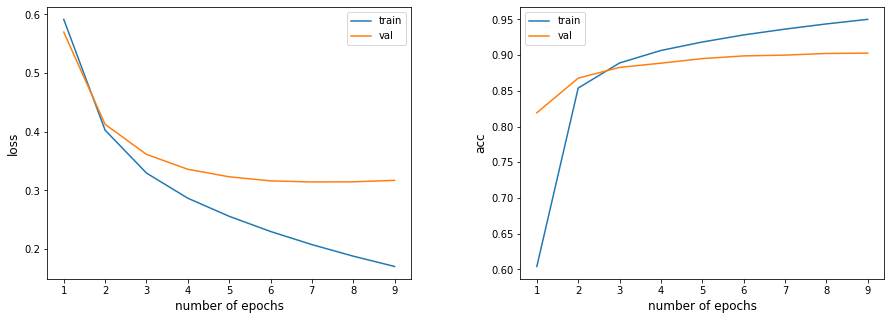

In [10]:
plot_summary(lstm_summary)

In [11]:
test(lstm_classifier, lstm_criterion, accuracy, X_test, y_test, tokenizer, max_len=32, batch_size=batch_size)

test loss: 0.3131; test acc: 0.9043


### CNN Text Classifier

In [12]:
embedding_dim = 300
output_size = NUM_CATEGORIES
out_channels = 128

cnn_classifier = CNN(output_size, embedding_dim, out_channels, word_vectors).cuda()

In [13]:
learning_rate = 1e-4

cnn_optimizer = torch.optim.Adam(cnn_classifier.parameters(), lr=learning_rate)
cnn_criterion = nn.CrossEntropyLoss()

In [14]:
batch_size = 64
n_epochs = 6

cnn_summary = train_and_evaluate(cnn_classifier, cnn_criterion, accuracy, cnn_optimizer, X_train, 
                                 y_train, X_val, y_val, tokenizer, max_len=32, batch_size=batch_size, n_epochs=n_epochs)

start training: 
--------------------------------------------------
epoch  1 :
train loss: 0.4590; train acc: 0.7131
eval loss: 0.4030; eval acc: 0.8731
--------------------------------------------------
epoch  2 :
train loss: 0.3341; train acc: 0.8853
eval loss: 0.3095; eval acc: 0.8952
--------------------------------------------------
epoch  3 :
train loss: 0.2778; train acc: 0.9093
eval loss: 0.2818; eval acc: 0.9054
--------------------------------------------------
epoch  4 :
train loss: 0.2445; train acc: 0.9233
eval loss: 0.2683; eval acc: 0.9100
--------------------------------------------------
epoch  5 :
train loss: 0.2106; train acc: 0.9337
eval loss: 0.2613; eval acc: 0.9121
--------------------------------------------------
epoch  6 :
train loss: 0.1894; train acc: 0.9428
eval loss: 0.2593; eval acc: 0.9146
--------------------------------------------------
finish training.


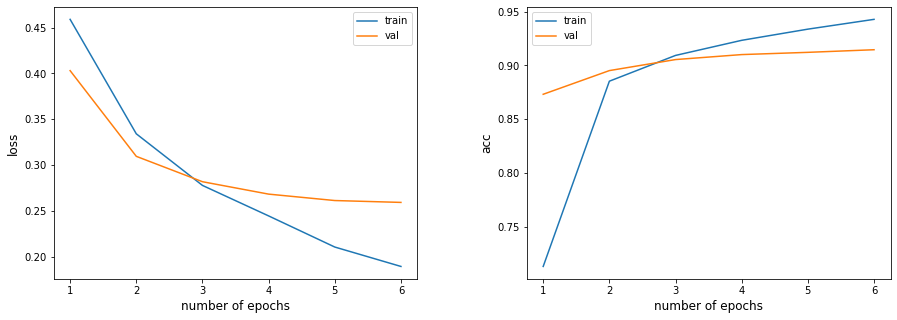

In [15]:
plot_summary(cnn_summary)

In [16]:
test(cnn_classifier, cnn_criterion, accuracy, X_test, y_test, tokenizer, max_len=32, batch_size=batch_size)

test loss: 0.2505; test acc: 0.9161
